In [1]:
import emcee
import corner
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [92]:
class TimeSeries():
    def __init__(self, time=None, size=1000, sampling_rate=1):
        '''
        Input
            time    (ndarray (n,))     time array
            size    (scalar)           size of time array
        '''

        # true values used to generate the time series
        # [sigma, log(h0), log(f), phi]
        self.truths = [0, 0, 0, 0]

        if time == None:
            self.time = np.arange(0, sampling_rate * size, sampling_rate)
        else:
            self.time = np.array(time)
        
        self.generate_noise()

    def generate_noise(self):
        '''
        Generate white noise
        Input
            sigma (scalar):     noise parameter <n_I n_J> = delta_{IJ}
        '''
        self.noise = np.random.normal(size=len(self.time))
        self.series = self.noise
        self.truths[0] = 1
    
    def generate_coherent_signal(self, amp:float, f: float, phi:float):
        '''
        Generate coherent signal
        Input
            f   (scalar):   frequency [Hz]
            phi (scalar):   phase
        '''
        
        self.signal = amp * np.cos(2. * np.pi * f * self.time + phi)
        self.series += self.signal
        self.truths[1] = np.log(amp)
        self.truths[2] = np.log(f)
        self.truths[3] = phi

    def plot(self):
        plt.plot(self.time, self.series)
        plt.plot(self.time, self.signal)

In [93]:
def log_likelihood(theta, x, y):
    '''
    Log-lilkelihood function
    Input
        theta (ndarray (n,))        parameters (sigma, h0, ln(f), phi)
        x     (ndarray (n,))        time stamp
        y     (ndarray (n,))        time series
    '''

    sigma, ln_h0, ln_f, phi = theta
    model = np.exp(ln_h0) * np.cos(2. * np.pi * np.exp(ln_f) * x + phi)
    return -0.5 * np.sum((y - model)**2 / sigma**2 + np.log(sigma**2))

def log_prior(theta):
    '''
    Log prior function; uniform prior is chosen
    Input
        theta (ndarray (n,))        parameters (sigma, h0, ln(f), phi)
    '''
    sigma, ln_h0, ln_f, phi = theta
    if (0.1 <= sigma <= 5.0 
        and -6.0 <= ln_h0 <= 2.0
        and -6.0 <= ln_f <= 0
        and 0 <= phi < 2 * np.pi):
        return 0.0
    else:
        return -np.inf
    
def log_prob(theta, x, y):
    '''
    Log posterior function
    Input
        theta (ndarray (n,))        parameters (sigma, h0, ln(f), phi)
        x     (ndarray (n,))        time stamp
        y     (ndarray (n,))        time series
    '''
    lp = log_prior(theta)
    
    if np.isinf(lp):
        return -np.inf
    else:
        return lp + log_likelihood(theta, x, y)

def draw_initial(nwalker):
    sigma = np.random.uniform(0.1, 5.0, nwalker)
    ln_h0 = np.random.uniform(-6.0, 2.0, nwalker)
    ln_f = np.random.uniform(-6.0, 0.0, nwalker)
    phi = np.random.uniform(0, 2 * np.pi, nwalker)

    return np.vstack((sigma, ln_h0, ln_f, phi)).T

In [100]:
size = int(1e+5)
time_stamp = sorted(np.arange(0, size) + 2 * np.random.random(size=size))

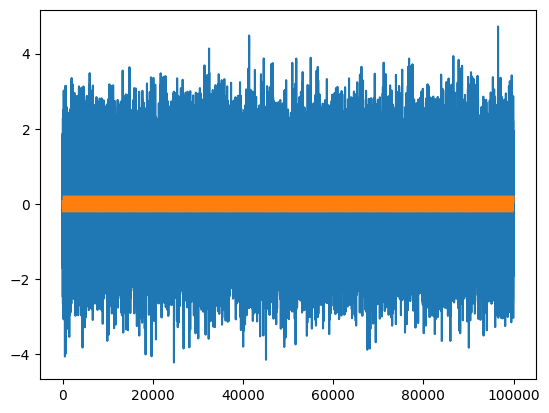

In [101]:
my = TimeSeries(time_stamp)
my.generate_coherent_signal(0.2, 0.003, 1.2)
my.plot()

In [102]:
coords = draw_initial(32)
nwalkers, ndim = coords.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(my.time, my.series))

In [103]:
sampler.run_mcmc(coords, 50000, progress=True);

100%|██████████| 50000/50000 [08:52<00:00, 93.81it/s] 


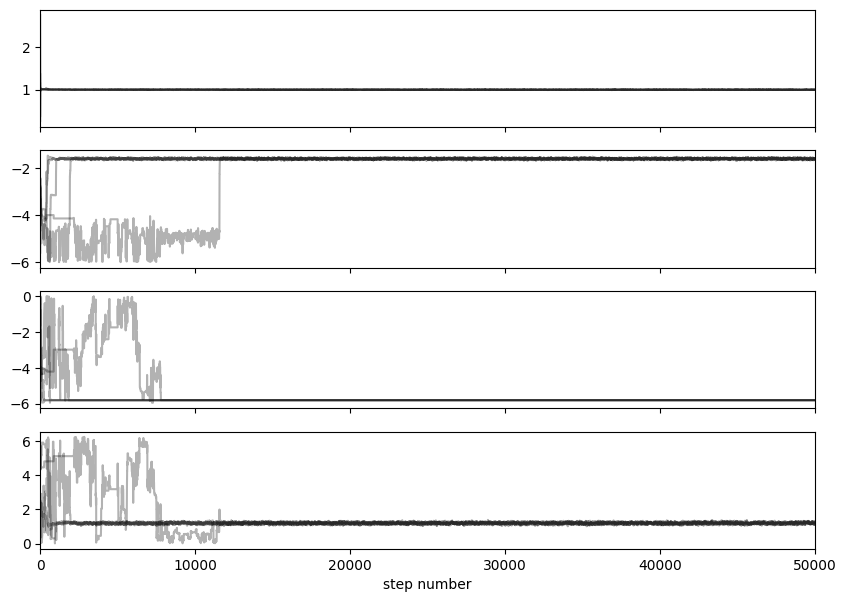

In [109]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)

samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :5, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    # ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [107]:
flat_samples = sampler.get_chain(discard=5000, thin=15, flat=True)

In [110]:
my_sample = np.concatenate(samples[20000:,:5, :4], axis=0)

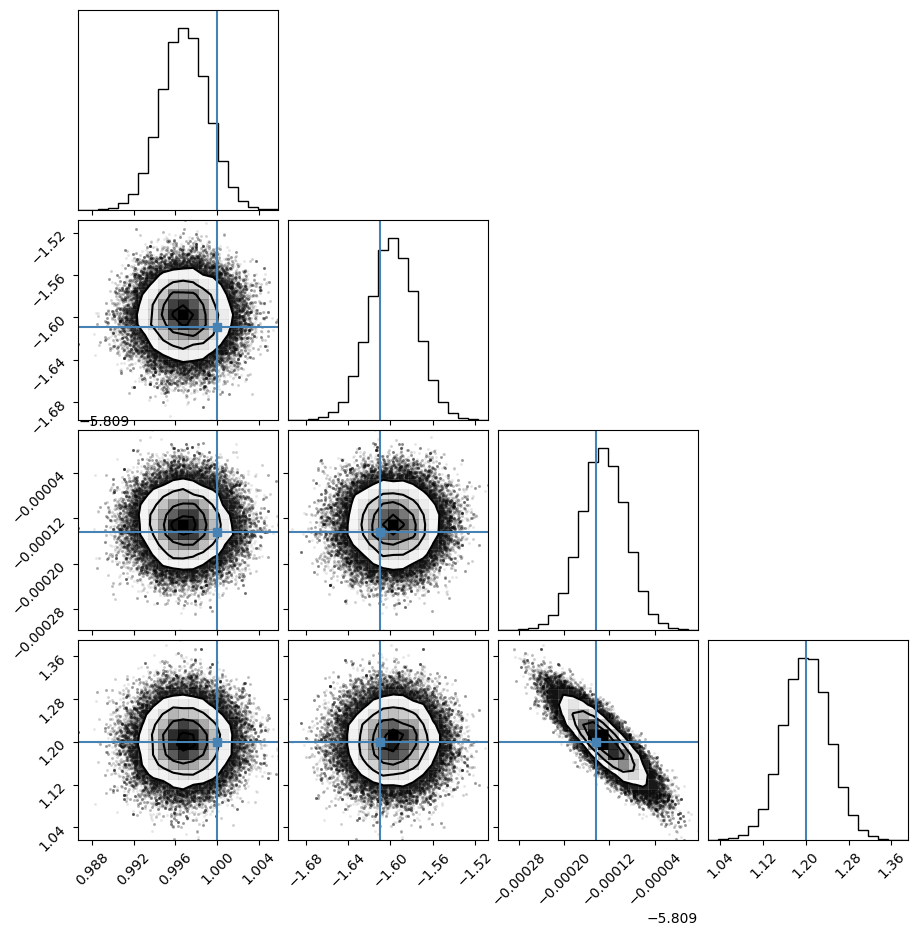

In [111]:
# fig = corner.corner(flat_samples,
#                     truths=my.truths);

fig = corner.corner(my_sample,
                    truths=my.truths);

# fig = corner.corner(samples[10000:,1, :3])

# Normalizing Flow

In [10]:
import sklearn.datasets as datasets

import torch
from torch import nn
from torch import optim

from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation

In [ ]:
x, y = datasets.make_moons(128, noise=.1)
plt.scatter(x[:, 0], x[:, 1]);